In [ ]:
import pandas as pd
Final_Dataset_Provider_Train = pd.read_csv('Final_Train.csv')
Final_Dataset_Provider_Test = pd.read_csv('Final_Test.csv')
from sklearn.impute import SimpleImputer


In [ ]:
# Seperate dependent and independent variables
x_train = Final_Dataset_Provider_Train.drop(axis=1,columns=['Provider','PotentialFraud'])
y_train = Final_Dataset_Provider_Train['PotentialFraud']
x_test = Final_Dataset_Provider_Test.drop(axis=1,columns=['Provider'])

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [ ]:

# Standardize the data (train and test)
standard_scaler = StandardScaler()
standard_scaler.fit(x_train)
x_train_std = standard_scaler.transform(x_train)
x_test_std = standard_scaler.transform(x_test)

In [ ]:

x_tr, x_val, y_tr, y_val = train_test_split(x_train_std, y_train, test_size=0.3,random_state=42,stratify=y_train)

In [ ]:
x_tr.shape, x_val.shape, y_tr.shape, y_val.shape

((3787, 246), (1623, 246), (3787,), (1623,))

In [ ]:
from collections import Counter
counter = Counter(y_tr)
fraud_percentage = (counter[1]*100/(counter[0]+counter[1]))
non_fraud_percentage = (counter[0]*100/(counter[0]+counter[1]))
print("Fraud Percentage = {:.2f}% and Non-Fraud Percentage = {:.2f}%".format(fraud_percentage, non_fraud_percentage))

Fraud Percentage = 9.35% and Non-Fraud Percentage = 90.65%


### Oversample the data using SMOTE to make it 20:80 ratio

The thing which we are doing for 20:80 is same as for other ratio's also, so if it apperaing to be very long to go through just see 20:80 and to go to end too see comparision bw different ratio's

In [ ]:
# https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/
from imblearn.over_sampling import SMOTE


# Create a SMOTE instance with the desired sampling strategy
oversample = SMOTE(sampling_strategy=0.25)

# Fit and transform the training data using SMOTE
x_tr_os, y_tr_os = oversample.fit_resample(x_tr, y_tr)


counter = Counter(y_tr_os)
fraud_percentage = (counter[1]*100/(counter[0]+counter[1]))
non_fraud_percentage = (counter[0]*100/(counter[0]+counter[1]))
print("Fraud Percentage = {:.2f}% and Non-Fraud Percentage = {:.2f}%".format(fraud_percentage, non_fraud_percentage))


Fraud Percentage = 20.00% and Non-Fraud Percentage = 80.00%


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn import metrics
from sklearn.metrics import roc_curve, auc , f1_score
from sklearn.metrics import confusion_matrix
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import RandomForestClassifier
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

### Use GridSearchCV to find best parameters for Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

# Create a parameter grid with "C" and "penalty" (only "l2")
grid = {
    "C": np.logspace(-3, 3, 7),
    "penalty": ["l2"]
}

# Create a LogisticRegression model
logreg = LogisticRegression()

# Create a GridSearchCV instance
logreg_cv = GridSearchCV(logreg, grid, cv=5, scoring="roc_auc", n_jobs=-1, return_train_score=True)

# Fit the GridSearchCV to your data
logreg_cv.fit(x_tr_os, y_tr_os)

# Print the results
print(logreg_cv)



GridSearchCV(cv=5, estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                         'penalty': ['l2']},
             return_train_score=True, scoring='roc_auc')


C:\Users\Gurram koushik reddy\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
print("best parameters = ",logreg_cv.best_params_)
print("roc_auc_score :",logreg_cv.best_score_)

best parameters =  {'C': 1.0, 'penalty': 'l2'}
roc_auc_score : 0.9392588248772071


In [ ]:
log_reg = LogisticRegression(C=0.1, penalty='l2')
log_reg.fit(x_tr_os, y_tr_os)

LogisticRegression(C=0.1)

In [ ]:
def pred_prob(clf, data):
    # predicts the probabability of class label using the model
    y_pred = clf.predict_proba(data)[:,1]
    return y_pred

def draw_roc(train_fpr, train_tpr, test_fpr, test_tpr):
    # calculate auc for train and test
    train_auc = auc(train_fpr, train_tpr)
    test_auc = auc(test_fpr, test_tpr)
    plt.plot(train_fpr, train_tpr, label="Train AUC ="+"{:.4f}".format(train_auc))
    plt.plot(test_fpr, test_tpr, label="Test AUC ="+"{:.4f}".format(test_auc))
    plt.legend()
    plt.xlabel("False Positive Rate(FPR)", size = 14)
    plt.ylabel("True Positive Rate(TPR)", size = 14)
    plt.title("Area Under Curve", size = 16)

    plt.grid(True)
    plt.show()
def find_best_threshold(threshold, fpr, tpr):
    t = threshold[np.argmax(tpr*(1-fpr))]
#     print("max(tpr*(1-fpr)) = ", max(tpr*(1-fpr)), "for threshold = ", np.round(t,3))
    return t

def predict_with_best_t(proba, threshold):
    predictions = []
    for i in proba:
        if i>=threshold:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

In [ ]:
from sklearn.metrics import confusion_matrix
def draw_confusion_matrix(best_t, x_train, x_test, y_train, y_test, y_train_pred, y_test_pred):
    # Confusion matrix for train and test dataset
    fig, ax = plt.subplots(1,2, figsize=(20,6))

    train_prediction = predict_with_best_t(y_train_pred, best_t)
    cm = confusion_matrix(y_train, train_prediction)
    sns.heatmap(cm, annot=True, fmt='d', ax=ax[0])
    ax[0].set_title('Train Dataset Confusion Matrix', size = 16)
    ax[0].set_xlabel("Predicted Label", size = 14)
    ax[0].set_ylabel("Actual Label", size = 14)

    test_prediction = predict_with_best_t(y_test_pred, best_t)
    cm = confusion_matrix(y_test, test_prediction)
    sns.heatmap(cm, annot=True, fmt='d', ax=ax[1])
    ax[1].set_title('Test Dataset Confusion Matrix', size = 16)
    ax[1].set_xlabel("Predicted Label", size = 14)
    ax[1].set_ylabel("Actual Label", size = 14)
    plt.grid()
    plt.show()

    return train_prediction, test_prediction

In [ ]:
def validate_model(clf, x_train, x_test, y_train, y_test):
    # predict the probability of train data
    y_train_pred = pred_prob(clf, x_train)
    # predict the probability of test data
    y_test_pred = pred_prob(clf, x_test)
    # calculate tpr, fpr for diffeent thresholds using roc_curve
    train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
    test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

    # calculate auc for train and test
    train_auc = auc(train_fpr, train_tpr)
    print("Train AUC = ", train_auc)
    test_auc = auc(test_fpr, test_tpr)
    print("Test AUC = ", test_auc)

    draw_roc(train_fpr, train_tpr, test_fpr, test_tpr)

    best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)

    train_prediction, test_prediction = draw_confusion_matrix(best_t, x_train, x_test, y_train, y_test, y_train_pred, y_test_pred)
#     print(len(test_prediction))

    train_f1_score = f1_score(y_train, train_prediction)
    test_f1_score = f1_score(y_test, test_prediction)

    return test_auc, test_f1_score, best_t

Train AUC =  0.9428055680604472
Test AUC =  0.9530349923074171


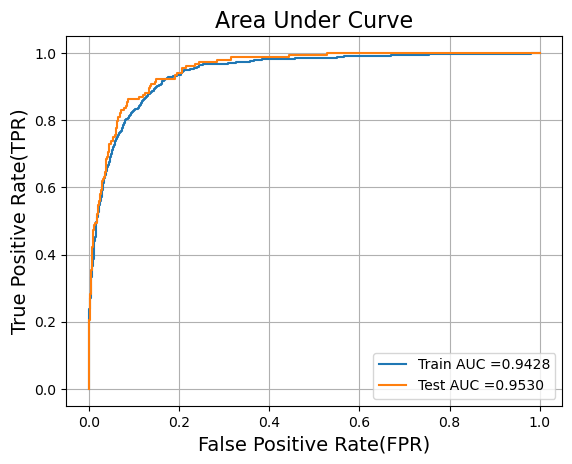

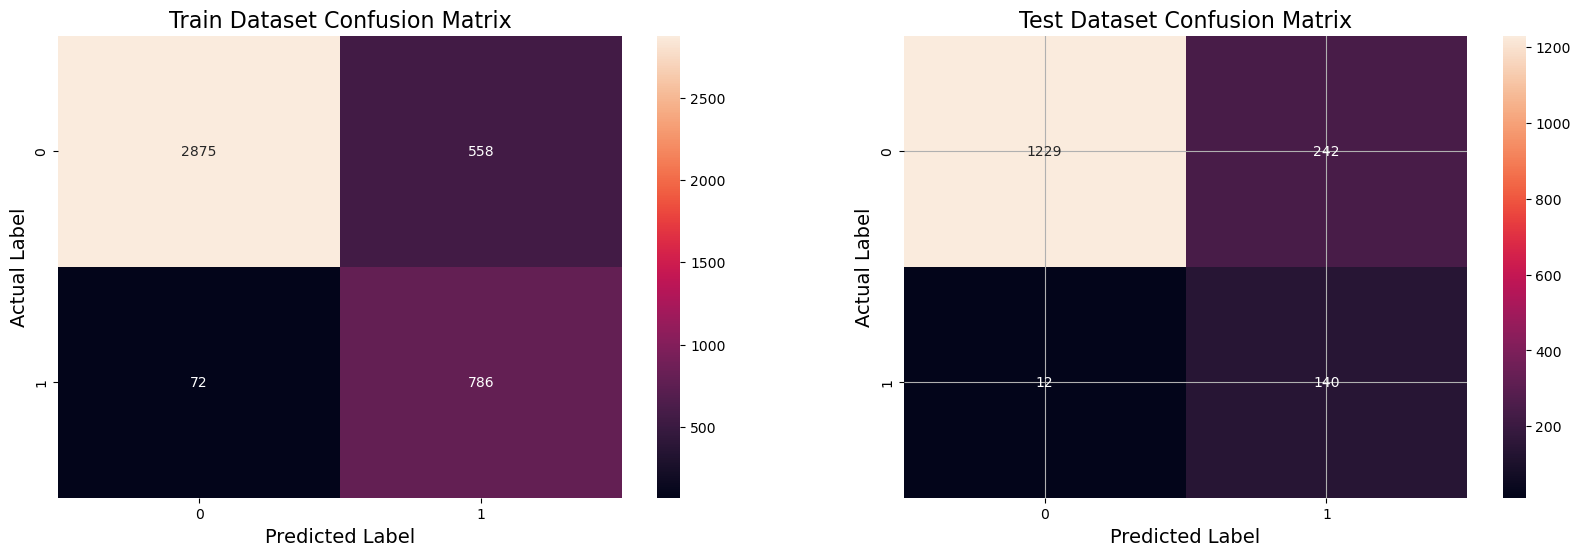

Model AUC is : 0.9530
Model F1 Score is : 0.5243


In [ ]:
# Validate LogisticRegression model
test_auc, test_f1_score, best_t = validate_model(log_reg, x_tr_os, x_val, y_tr_os, y_val)


print("Model AUC is : {:.4f}".format(test_auc))
print("Model F1 Score is : {:.4f}".format(test_f1_score))

### Use GridSearchCV for DecisionTreeClassifier

In [ ]:
decisiontree = DecisionTreeClassifier() #class_weight = 'balanced'

parameters = {'criterion':['gini','entropy'], 'max_depth': [5, 10, 50, 100, 150, 200, 250, 500], 'min_samples_split': [5, 10, 50, 100, 150, 200, 250, 500]}

decisiontree_cv = GridSearchCV(decisiontree, parameters, cv=5, scoring='roc_auc', n_jobs=-1, return_train_score=True)
decisiontree_cv.fit(x_tr_os, y_tr_os)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [5, 10, 50, 100, 150, 200, 250, 500],
                         'min_samples_split': [5, 10, 50, 100, 150, 200, 250,
                                               500]},
             return_train_score=True, scoring='roc_auc')

In [ ]:
print("best parameters = ",decisiontree_cv.best_params_)
print("roc_auc_score :",decisiontree_cv.best_score_)

best parameters =  {'criterion': 'gini', 'max_depth': 100, 'min_samples_split': 200}
roc_auc_score : 0.9383254030920319


### Train DecisionTreeClassifier with best hyperparameters

In [ ]:
decision_tree = DecisionTreeClassifier(max_depth = 10, min_samples_split = 250)
decision_tree.fit(x_tr_os, y_tr_os)

DecisionTreeClassifier(max_depth=10, min_samples_split=250)

Train AUC =  0.9578873161017059
Test AUC =  0.9111640845826326


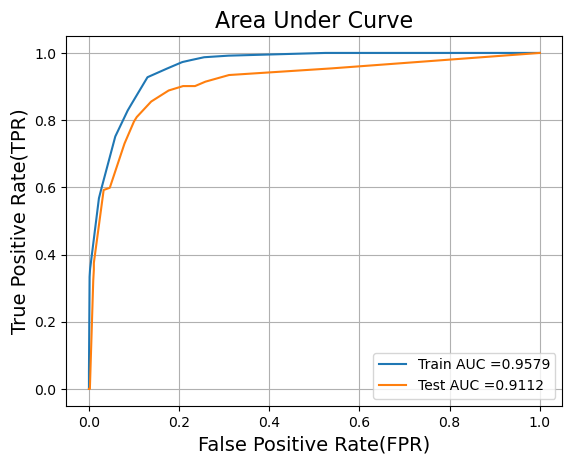

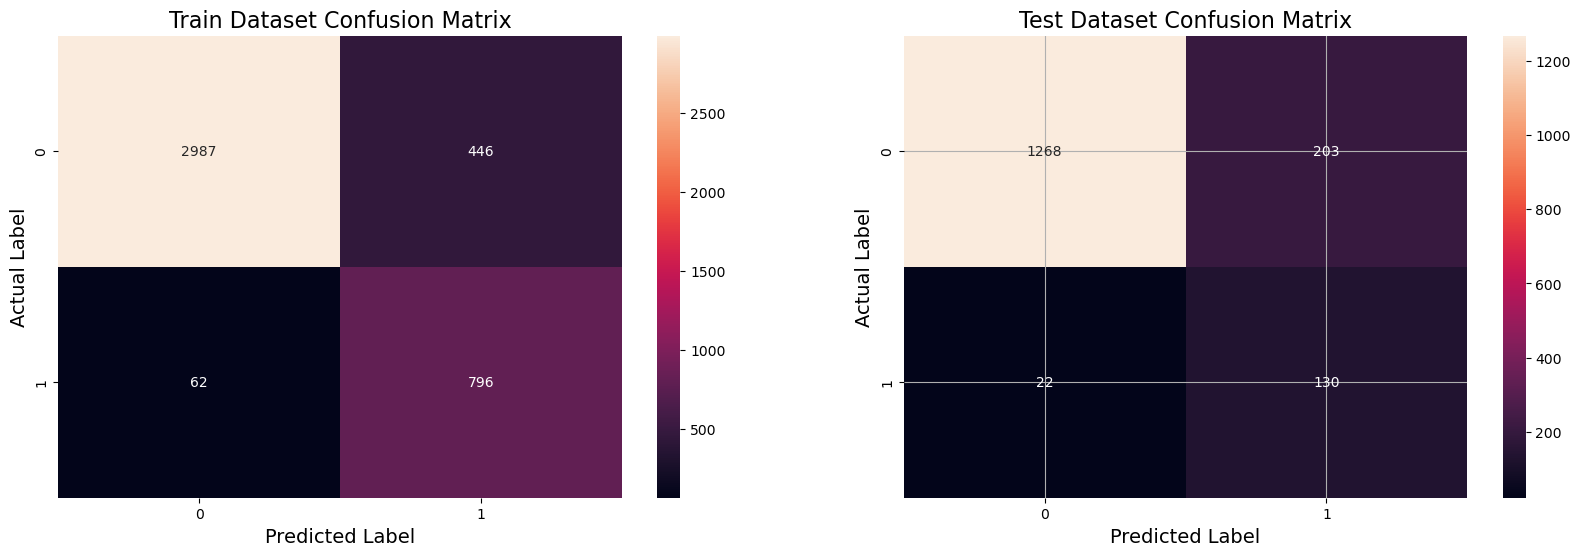

Best Threshold = 0.3333
Model AUC is : 0.9112
Model F1 Score is : 0.5361


In [ ]:
# Validate Decision Tree model
test_auc, test_f1_score, best_t = validate_model(decision_tree, x_tr_os, x_val, y_tr_os, y_val)

print("Best Threshold = {:.4f}".format(best_t))
print("Model AUC is : {:.4f}".format(test_auc))
print("Model F1 Score is : {:.4f}".format(test_f1_score))

### Use RandomSearchCV for SupportVectorClassifier

In [ ]:
grid = {"C": [0.5, 1.0], "penalty": ["l2"]}
svm_clf = svm.LinearSVC(dual=False)  # Set dual=False
svm_cv = GridSearchCV(svm_clf, grid, cv=5, scoring='roc_auc', n_jobs=-1, return_train_score=True)
svm_cv.fit(x_tr_os, y_tr_os)


GridSearchCV(cv=5, estimator=LinearSVC(dual=False), n_jobs=-1,
             param_grid={'C': [0.5, 1.0], 'penalty': ['l2']},
             return_train_score=True, scoring='roc_auc')

In [ ]:
print("best parameters = ",svm_cv.best_params_)
print("roc_auc_score :",svm_cv.best_score_)

best parameters =  {'C': 0.5, 'penalty': 'l2'}
roc_auc_score : 0.9366096387222299


In [ ]:
from sklearn.calibration import CalibratedClassifierCV
from sklearn.svm import LinearSVC

# Create a LinearSVC classifier with specified parameters
linear_svc = LinearSVC(C=1.0, penalty='l2', dual=False, max_iter=10000)

# Create a CalibratedClassifierCV to calibrate the probabilities
clb_clf_svc = CalibratedClassifierCV(linear_svc)

# Fit the model to your data
clb_clf_svc.fit(x_tr_os, y_tr_os)


CalibratedClassifierCV(estimator=LinearSVC(dual=False, max_iter=10000))

Train AUC =  0.9498902398698496
Test AUC =  0.93777058213174


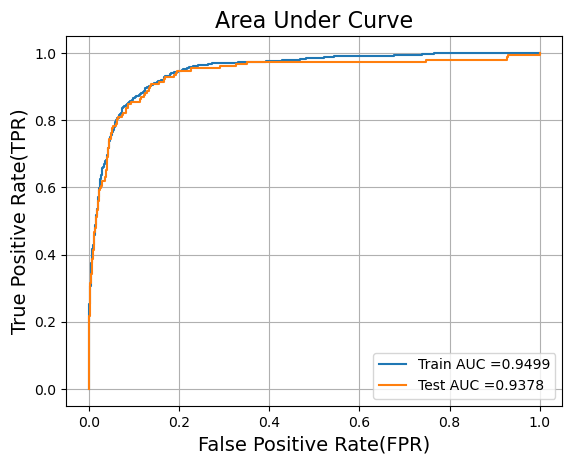

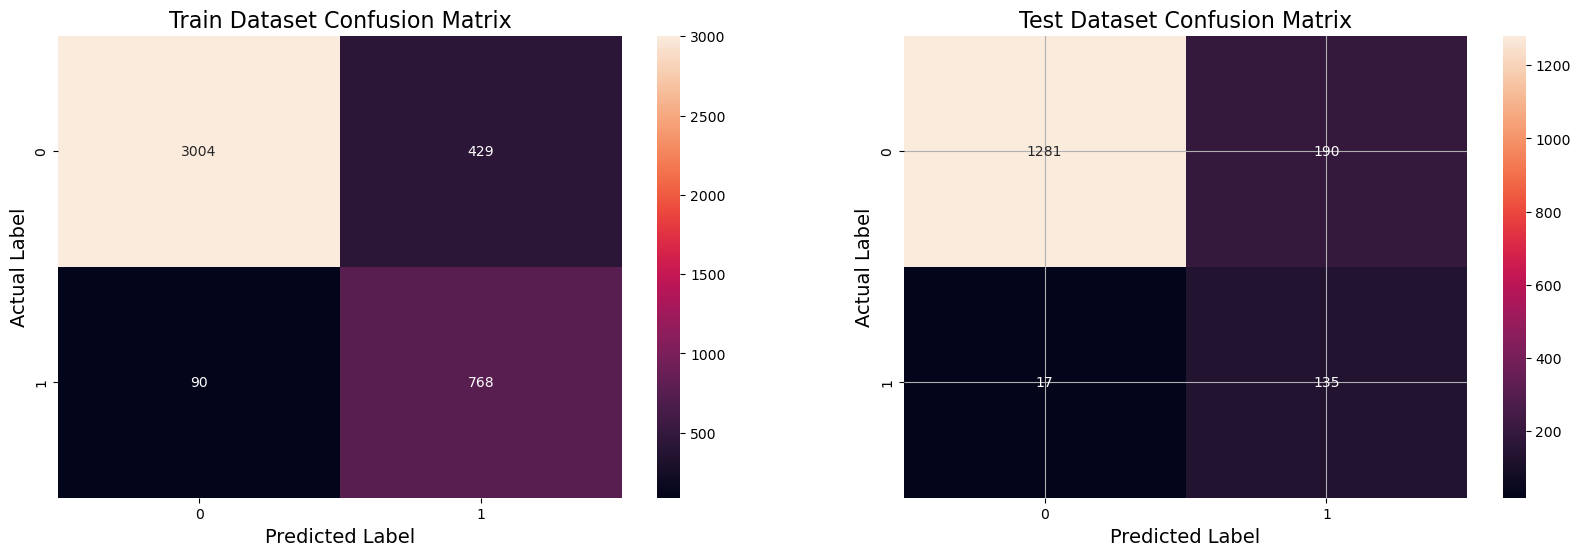

Best Threshold = 0.1365
Model AUC is : 0.9378
Model F1 Score is : 0.5660


In [ ]:
# Validate SVC model
test_auc, test_f1_score, best_t = validate_model(clb_clf_svc, x_tr_os, x_val, y_tr_os, y_val)

print("Best Threshold = {:.4f}".format(best_t))
print("Model AUC is : {:.4f}".format(test_auc))
print("Model F1 Score is : {:.4f}".format(test_f1_score))

### Train GaussianNB Classifier

In [ ]:
#Create a Gaussian Classifier
gaussian_nb = GaussianNB()
gaussian_nb.fit(x_tr_os, y_tr_os)

GaussianNB()

Train AUC =  0.8553800796737003
Test AUC =  0.881742191133851


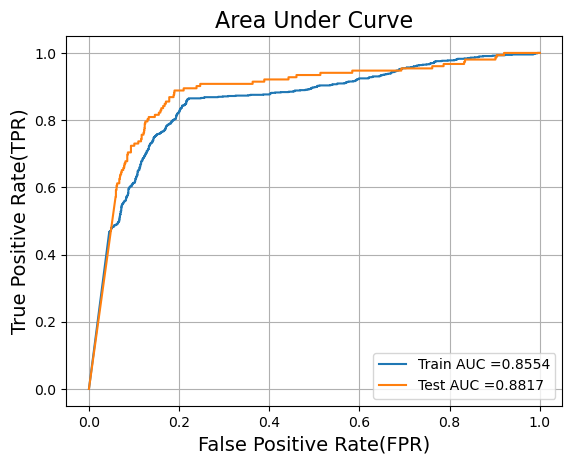

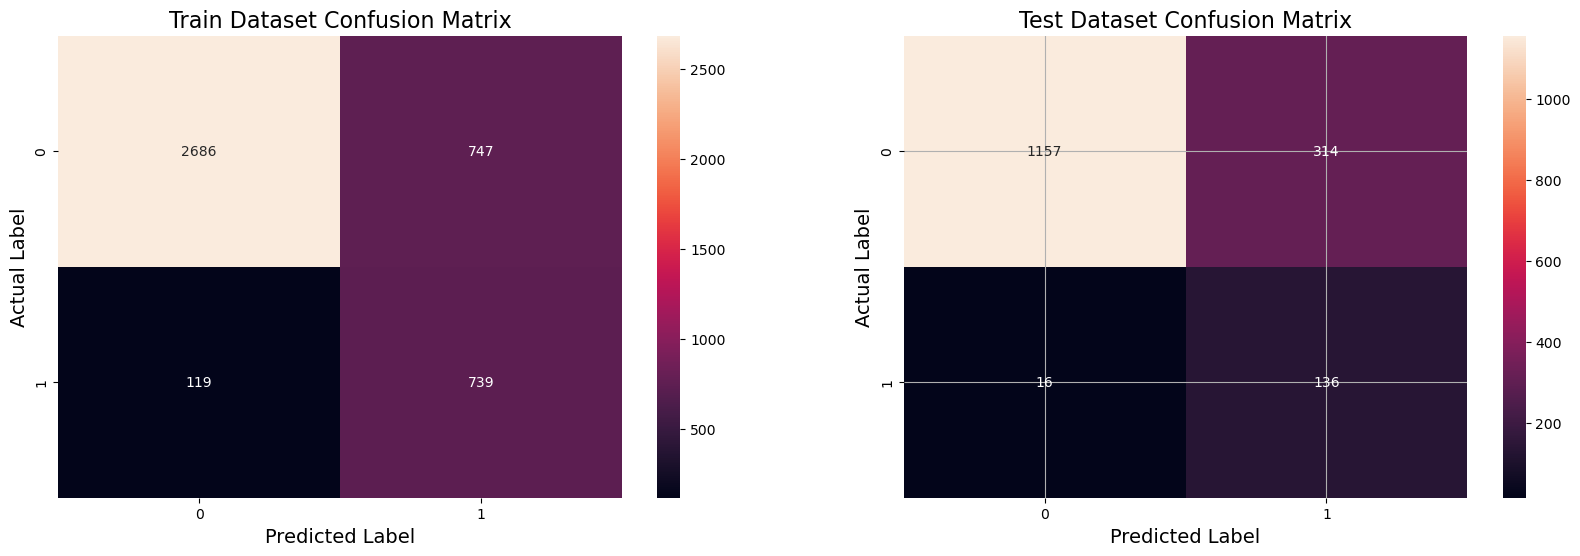

Best Threshold = 0.0000
Model AUC is : 0.8817
Model F1 Score is : 0.4518


In [ ]:
# Validate NB model
test_auc, test_f1_score, best_t = validate_model(gaussian_nb, x_tr_os, x_val, y_tr_os, y_val)

print("Best Threshold = {:.4f}".format(best_t))
print("Model AUC is : {:.4f}".format(test_auc))
print("Model F1 Score is : {:.4f}".format(test_f1_score))

### Observation on models for oversampling (20:80) data

In [ ]:
pip install beautifultable


Note: you may need to restart the kernel to use updated packages.


In [ ]:
#reference :https://stackoverflow.com/questions/8356501/python-format-tabular-output
from beautifultable import BeautifulTable
table = BeautifulTable()
table.column_headers= ["Model Name", "AUC", "F1 Score"]
table.append_row(["Logistic Regression", "0.95", "0.52"])
table.append_row(["Decision Tree", "0.90", "0.53"])
table.append_row(["Support Vector Classifier", "0.94", "0.56"])
table.append_row(["Naive Bayes", "0.88", "0.45"])
print(table)

+---------------------------+------+----------+
|        Model Name         | AUC  | F1 Score |
+---------------------------+------+----------+
|    Logistic Regression    | 0.95 |   0.52   |
+---------------------------+------+----------+
|       Decision Tree       | 0.9  |   0.53   |
+---------------------------+------+----------+
| Support Vector Classifier | 0.94 |   0.56   |
+---------------------------+------+----------+
|        Naive Bayes        | 0.88 |   0.45   |
+---------------------------+------+----------+


C:\Users\Gurram koushik reddy\anaconda3\Lib\site-packages\beautifultable\utils.py:125: FutureWarning: 'BeautifulTable.column_headers' has been deprecated in 'v1.0.0' and will be removed in 'v1.2.0'. Use 'BTColumnCollection.header' instead.
  warnings.warn(message, FutureWarning)
C:\Users\Gurram koushik reddy\anaconda3\Lib\site-packages\beautifultable\utils.py:125: FutureWarning: 'BeautifulTable.append_row' has been deprecated in 'v1.0.0' and will be removed in 'v1.2.0'. Use 'BTRowCollection.append' instead.
  warnings.warn(message, FutureWarning)


### Conclusion:
    After comparing AUC and F1 scores accross all the models, I can observe that LogisticRegression performs the best and SVC is the 2nd best.

### Oversample the data using SMOTE to make it 25:75 ratio

In [ ]:
oversample = SMOTE(sampling_strategy=0.33)
x_tr_os, y_tr_os = oversample.fit_resample(x_tr, y_tr)
counter = Counter(y_tr_os)
fraud_percentage = (counter[1]*100/(counter[0]+counter[1]))
non_fraud_percentage = (counter[0]*100/(counter[0]+counter[1]))
print("Fraud Percentage = {:.2f}% and Non-Fraud Percentage = {:.2f}%".format(fraud_percentage, non_fraud_percentage))

Fraud Percentage = 24.80% and Non-Fraud Percentage = 75.20%


### Train with LogisticRegression model

In [ ]:
log_reg = LogisticRegression(C=0.1, penalty='l2')
log_reg.fit(x_tr_os, y_tr_os)

C:\Users\Gurram koushik reddy\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(C=0.1)

Train AUC =  0.9485344901234021
Test AUC =  0.9507361622956099


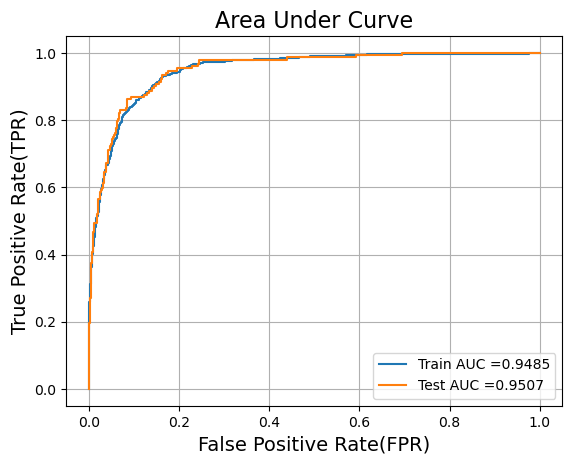

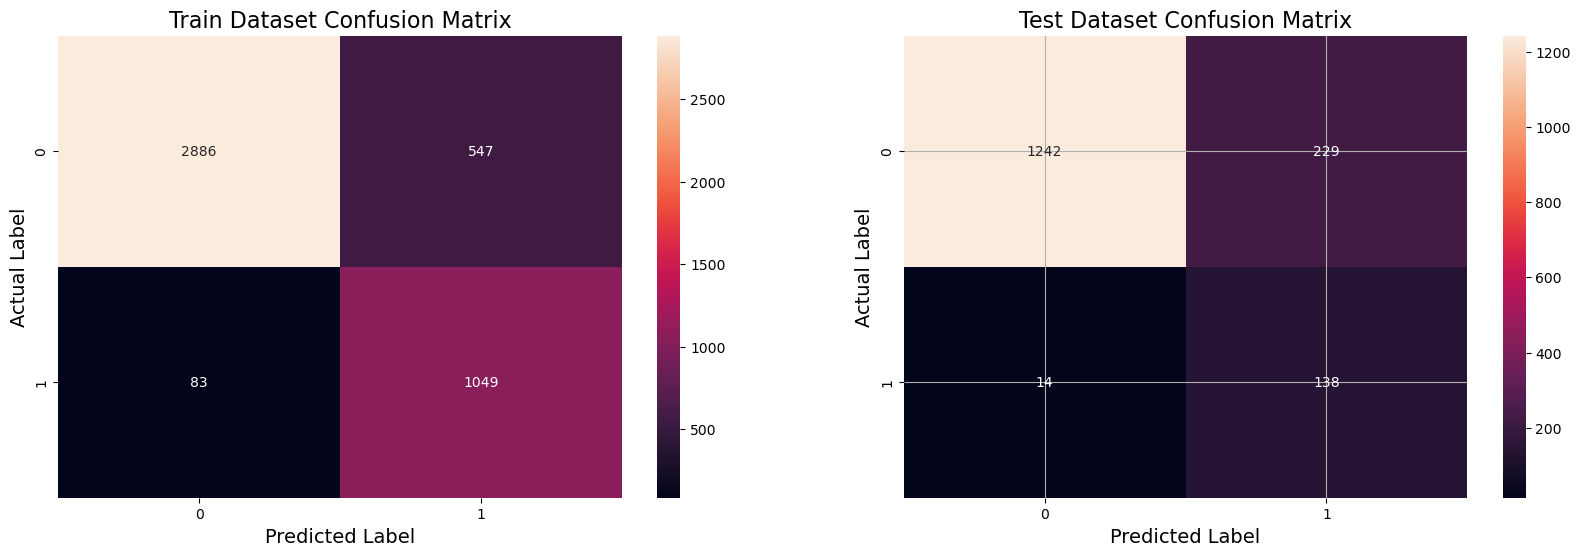

Best Threshold = 0.1327
Model AUC is : 0.9507
Model F1 Score is : 0.5318


In [ ]:
# Validate LogisticRegression model
test_auc, test_f1_score, best_t = validate_model(log_reg, x_tr_os, x_val, y_tr_os, y_val)

print("Best Threshold = {:.4f}".format(best_t))
print("Model AUC is : {:.4f}".format(test_auc))
print("Model F1 Score is : {:.4f}".format(test_f1_score))

### Train with DecisionTreeClassifier

In [ ]:
decision_tree = DecisionTreeClassifier(max_depth = 10, min_samples_split = 250)
decision_tree.fit(x_tr_os, y_tr_os)

DecisionTreeClassifier(max_depth=10, min_samples_split=250)

Train AUC =  0.9632050283107523
Test AUC =  0.9160256180900928


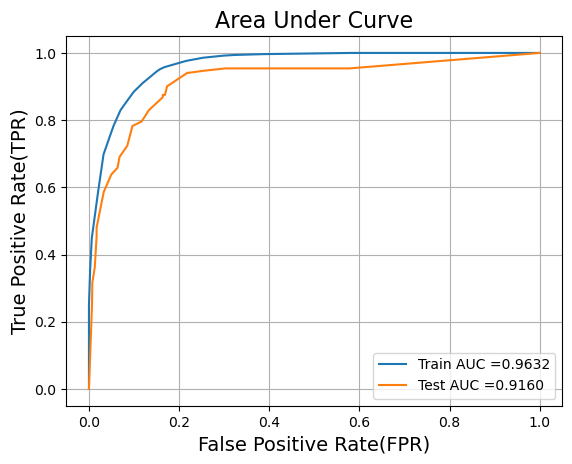

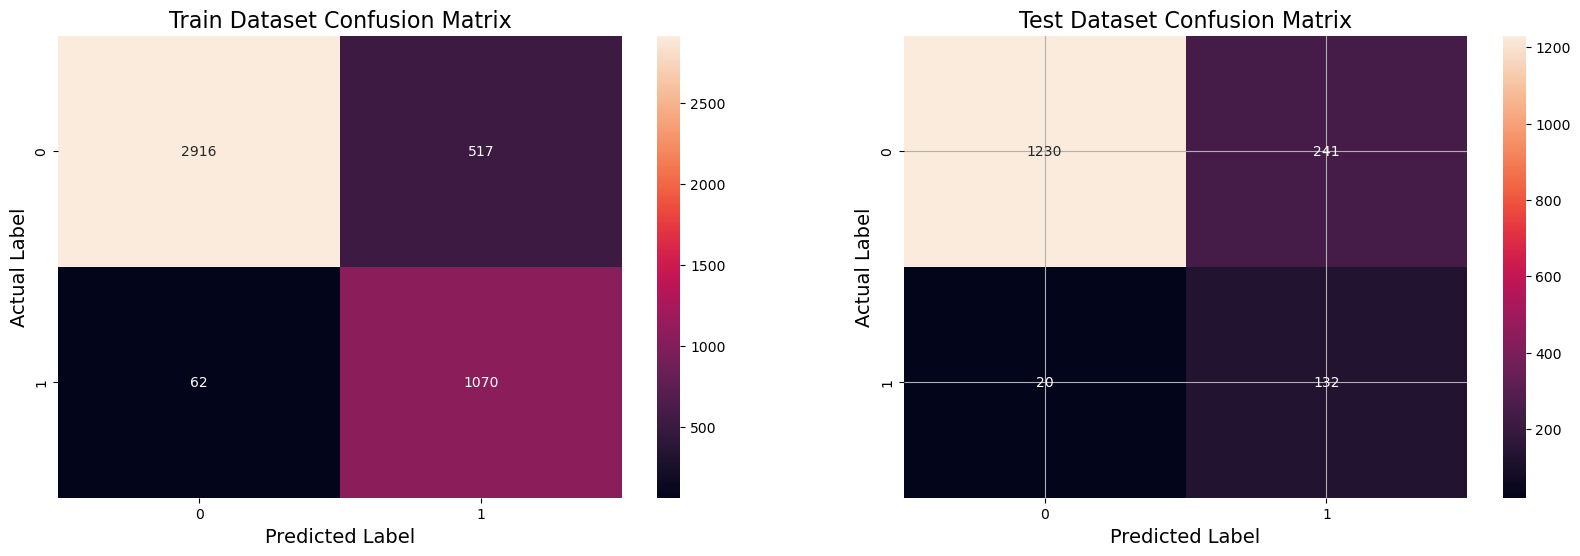

Best Threshold = 0.2685
Model AUC is : 0.9160
Model F1 Score is : 0.5029


In [ ]:
# Validate Decision Tree model
test_auc, test_f1_score, best_t = validate_model(decision_tree, x_tr_os, x_val, y_tr_os, y_val)

print("Best Threshold = {:.4f}".format(best_t))
print("Model AUC is : {:.4f}".format(test_auc))
print("Model F1 Score is : {:.4f}".format(test_f1_score))

### Train with Support Vector Classifier

In [ ]:
linear_svc = LinearSVC(C=1.0, penalty='l2')
clb_clf_svc = CalibratedClassifierCV(linear_svc)
clb_clf_svc.fit(x_tr_os, y_tr_os)

C:\Users\Gurram koushik reddy\anaconda3\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
C:\Users\Gurram koushik reddy\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Gurram koushik reddy\anaconda3\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
C:\Users\Gurram koushik reddy\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Gurram koushik reddy\anaconda3\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dua

CalibratedClassifierCV(estimator=LinearSVC())

Train AUC =  0.9567701348067345
Test AUC =  0.9438799241475545


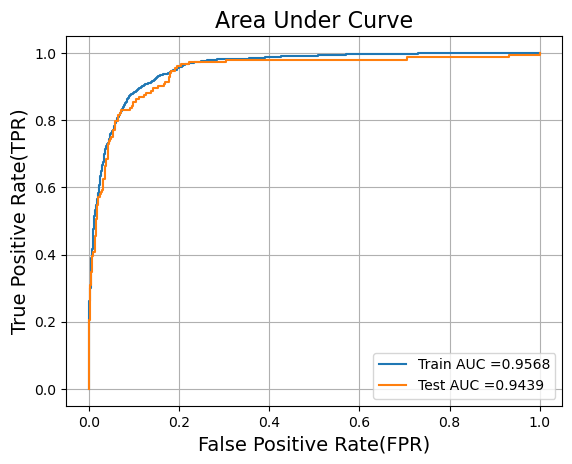

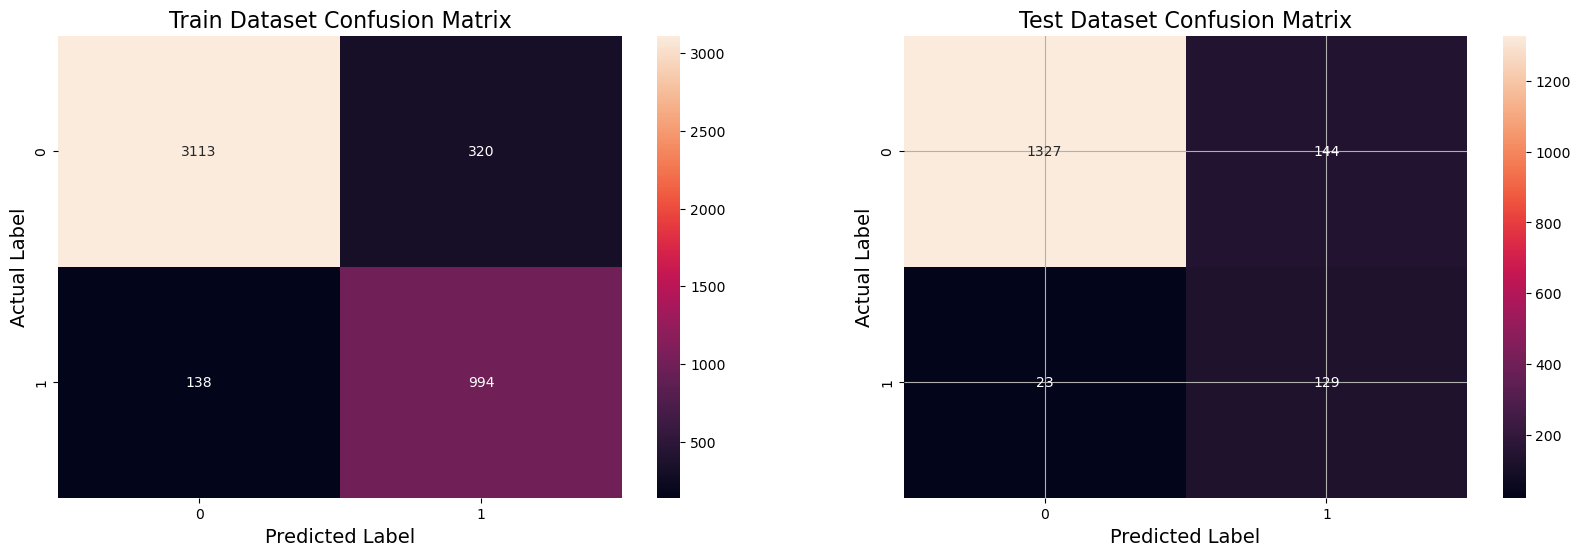

Best Threshold = 0.2116
Model AUC is : 0.9439
Model F1 Score is : 0.6071


In [ ]:
# Validate SVC model
test_auc, test_f1_score, best_t = validate_model(clb_clf_svc, x_tr_os, x_val, y_tr_os, y_val)

print("Best Threshold = {:.4f}".format(best_t))
print("Model AUC is : {:.4f}".format(test_auc))
print("Model F1 Score is : {:.4f}".format(test_f1_score))

### Train with NaiveBayes

In [ ]:
#Create a Gaussian Classifier
gaussian_nb = GaussianNB()
gaussian_nb.fit(x_tr_os, y_tr_os)

GaussianNB()

Train AUC =  0.8611576581073945
Test AUC =  0.8796066048874738


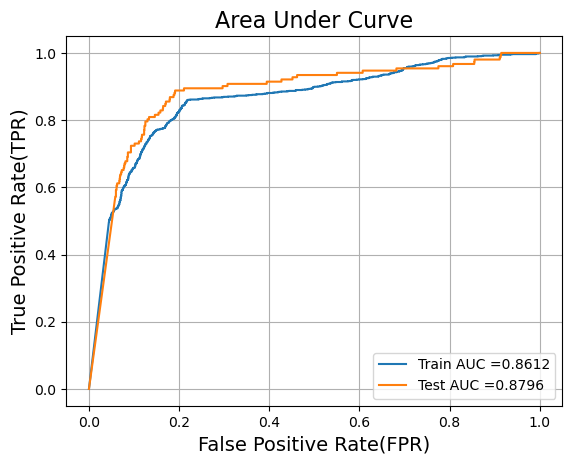

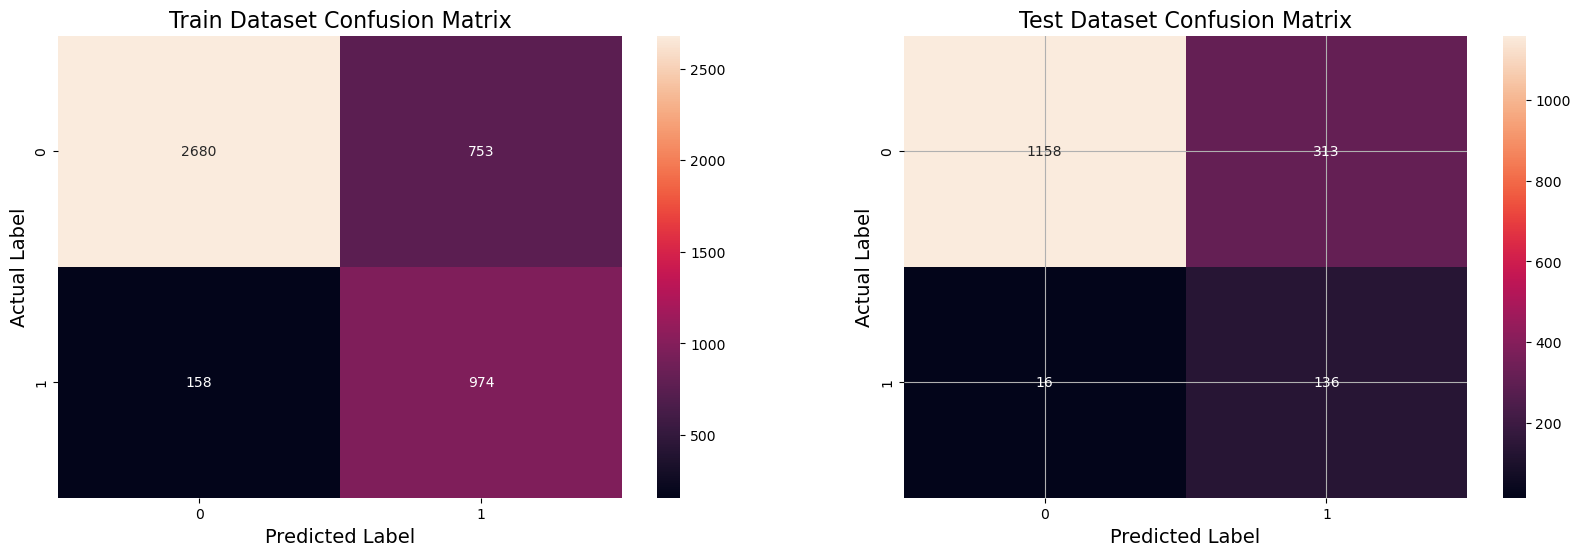

Best Threshold = 0.0000
Model AUC is : 0.8796
Model F1 Score is : 0.4526


In [ ]:
# Validate NB model
test_auc, test_f1_score, best_t = validate_model(gaussian_nb, x_tr_os, x_val, y_tr_os, y_val)

print("Best Threshold = {:.4f}".format(best_t))
print("Model AUC is : {:.4f}".format(test_auc))
print("Model F1 Score is : {:.4f}".format(test_f1_score))

In [ ]:
table = BeautifulTable()
table.column_headers= ["Model Name", "AUC", "F1 Score"]
table.append_row(["Logistic Regression", "0.95", "0.53"])
table.append_row(["Decision Tree", "0.92", "0.50"])
table.append_row(["Support Vector Classifier", "0.94", "0.60"])
table.append_row(["Naive Bayes", "0.88", "0.45"])
print(table)

+---------------------------+------+----------+
|        Model Name         | AUC  | F1 Score |
+---------------------------+------+----------+
|    Logistic Regression    | 0.95 |   0.53   |
+---------------------------+------+----------+
|       Decision Tree       | 0.92 |   0.5    |
+---------------------------+------+----------+
| Support Vector Classifier | 0.94 |   0.6    |
+---------------------------+------+----------+
|        Naive Bayes        | 0.88 |   0.45   |
+---------------------------+------+----------+


### Conclusion:
    After comparing AUC and F1 scores accross all the models, I can observe that LogisticRegression performs the best and SVC is the 2nd best for 25:75 ratio sampled data.

### Oversample the data using SMOTE to make it 35:65 ratio

In [ ]:
oversample = SMOTE(sampling_strategy=0.54)
x_tr_os, y_tr_os = oversample.fit_resample(x_tr, y_tr)
counter = Counter(y_tr_os)
fraud_percentage = (counter[1]*100/(counter[0]+counter[1]))
non_fraud_percentage = (counter[0]*100/(counter[0]+counter[1]))
print("Fraud Percentage = {:.2f}% and Non-Fraud Percentage = {:.2f}%".format(fraud_percentage, non_fraud_percentage))

Fraud Percentage = 35.05% and Non-Fraud Percentage = 64.95%


### Train with LogisticRegression model

In [ ]:
log_reg = LogisticRegression(C=0.1, penalty='l2')
log_reg.fit(x_tr_os, y_tr_os)

C:\Users\Gurram koushik reddy\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(C=0.1)

Train AUC =  0.9482344075132492
Test AUC =  0.9479453647715482


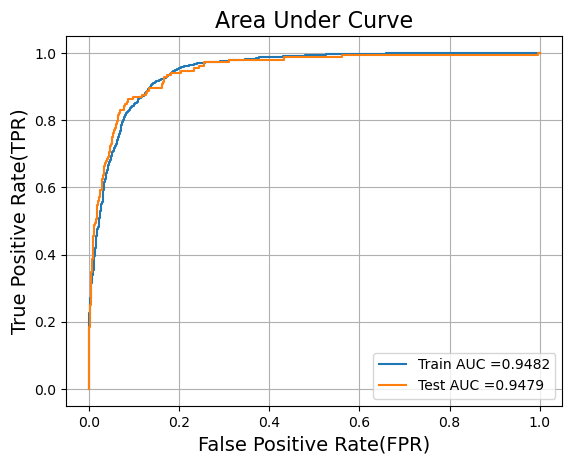

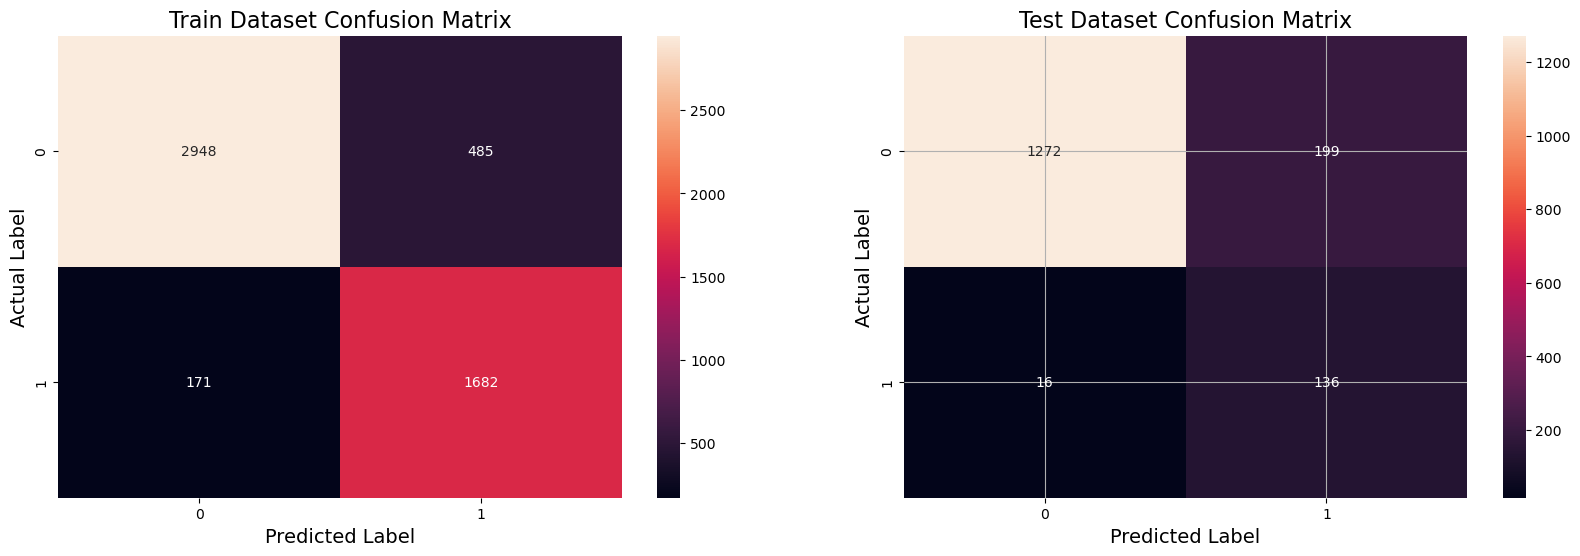

Best Threshold = 0.2207
Model AUC is : 0.9479
Model F1 Score is : 0.5585


In [ ]:
# Validate LogisticRegression model
test_auc, test_f1_score, best_t = validate_model(log_reg, x_tr_os, x_val, y_tr_os, y_val)

print("Best Threshold = {:.4f}".format(best_t))
print("Model AUC is : {:.4f}".format(test_auc))
print("Model F1 Score is : {:.4f}".format(test_f1_score))

### Train with DecisionTreeClassifier

In [ ]:
decision_tree = DecisionTreeClassifier(max_depth = 10, min_samples_split = 250)
decision_tree.fit(x_tr_os, y_tr_os)

DecisionTreeClassifier(max_depth=10, min_samples_split=250)

Train AUC =  0.9646225195316276
Test AUC =  0.886635031664818


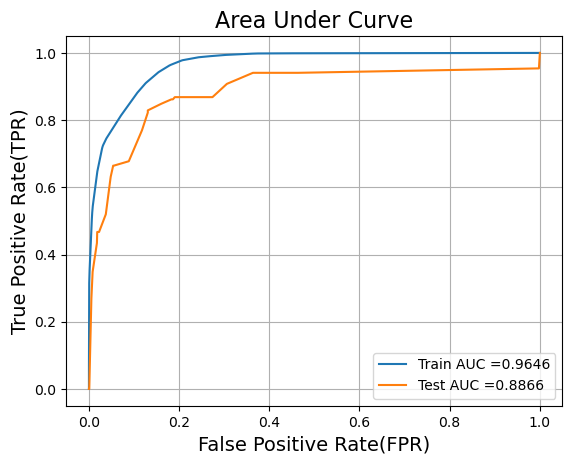

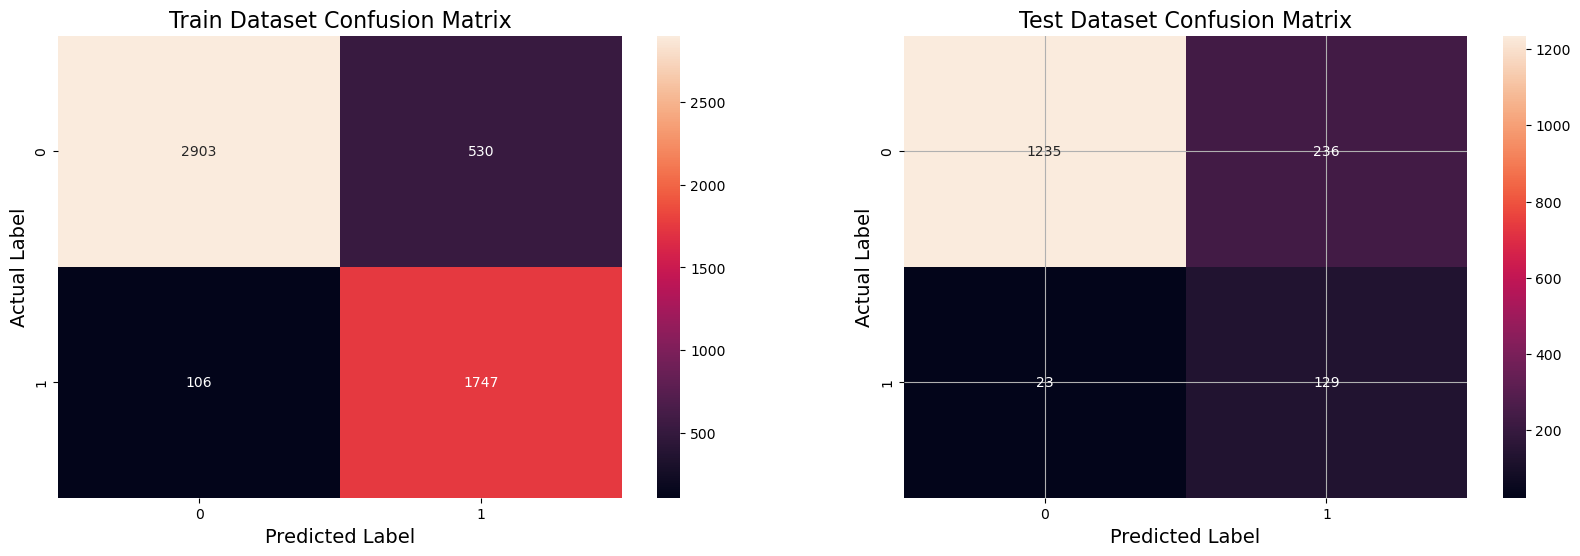

Best Threshold = 0.3816
Model AUC is : 0.8866
Model F1 Score is : 0.4990


In [ ]:
# Validate Decision Tree model
test_auc, test_f1_score, best_t = validate_model(decision_tree, x_tr_os, x_val, y_tr_os, y_val)

print("Best Threshold = {:.4f}".format(best_t))
print("Model AUC is : {:.4f}".format(test_auc))
print("Model F1 Score is : {:.4f}".format(test_f1_score))

### Train with Support Vector Classifier

In [ ]:
linear_svc = LinearSVC(C=1.0, penalty='l2')
clb_clf_svc = CalibratedClassifierCV(linear_svc)
clb_clf_svc.fit(x_tr_os, y_tr_os)

C:\Users\Gurram koushik reddy\anaconda3\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
C:\Users\Gurram koushik reddy\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Gurram koushik reddy\anaconda3\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
C:\Users\Gurram koushik reddy\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Gurram koushik reddy\anaconda3\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dua

CalibratedClassifierCV(estimator=LinearSVC())

Train AUC =  0.9549301571097577
Test AUC =  0.9338393144656338


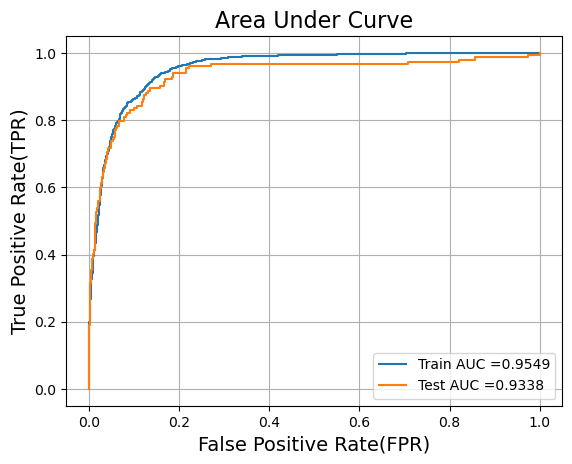

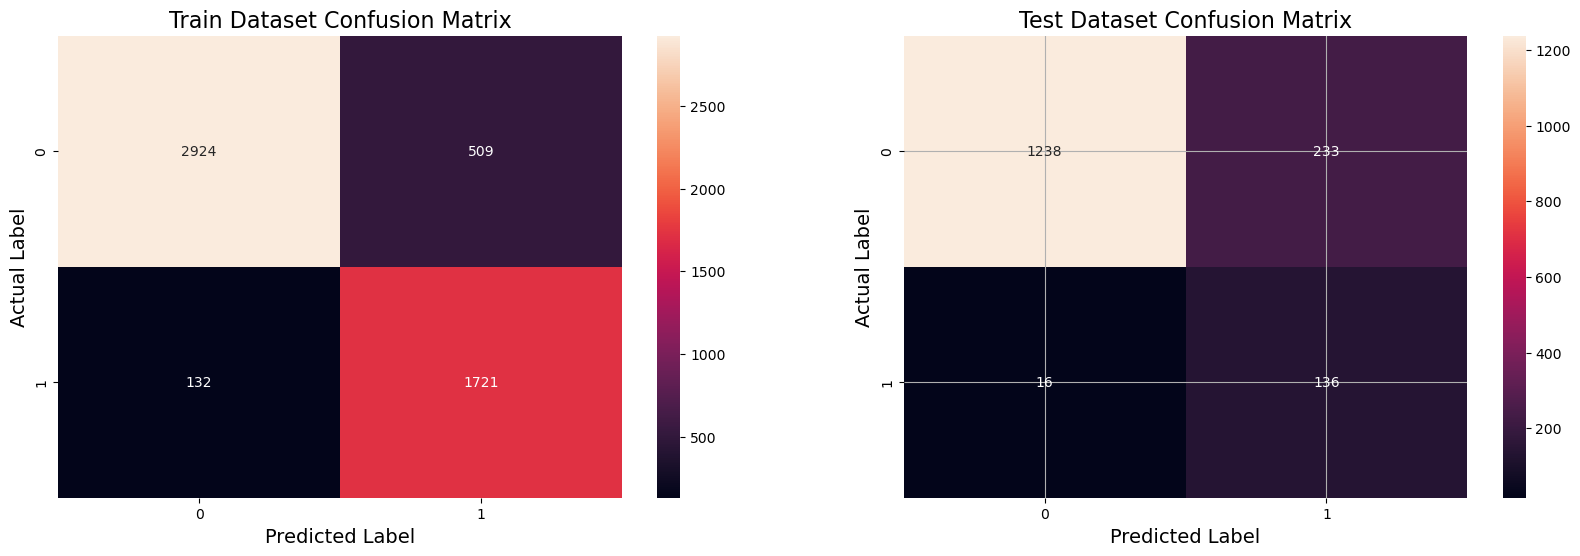

Best Threshold = 0.2323
Model AUC is : 0.9338
Model F1 Score is : 0.5221


In [ ]:
# Validate SVC model
test_auc, test_f1_score, best_t = validate_model(clb_clf_svc, x_tr_os, x_val, y_tr_os, y_val)

print("Best Threshold = {:.4f}".format(best_t))
print("Model AUC is : {:.4f}".format(test_auc))
print("Model F1 Score is : {:.4f}".format(test_f1_score))

### Train with NaiveBayes

In [ ]:
#Create a Gaussian Classifier
gaussian_nb = GaussianNB()
gaussian_nb.fit(x_tr_os, y_tr_os)

GaussianNB()

Train AUC =  0.8526029620446859
Test AUC =  0.8813620344198361


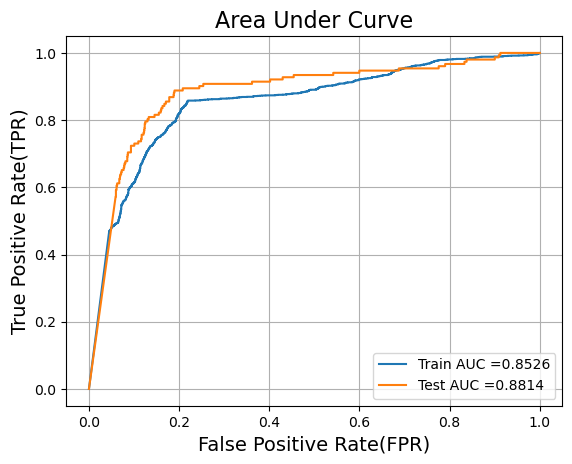

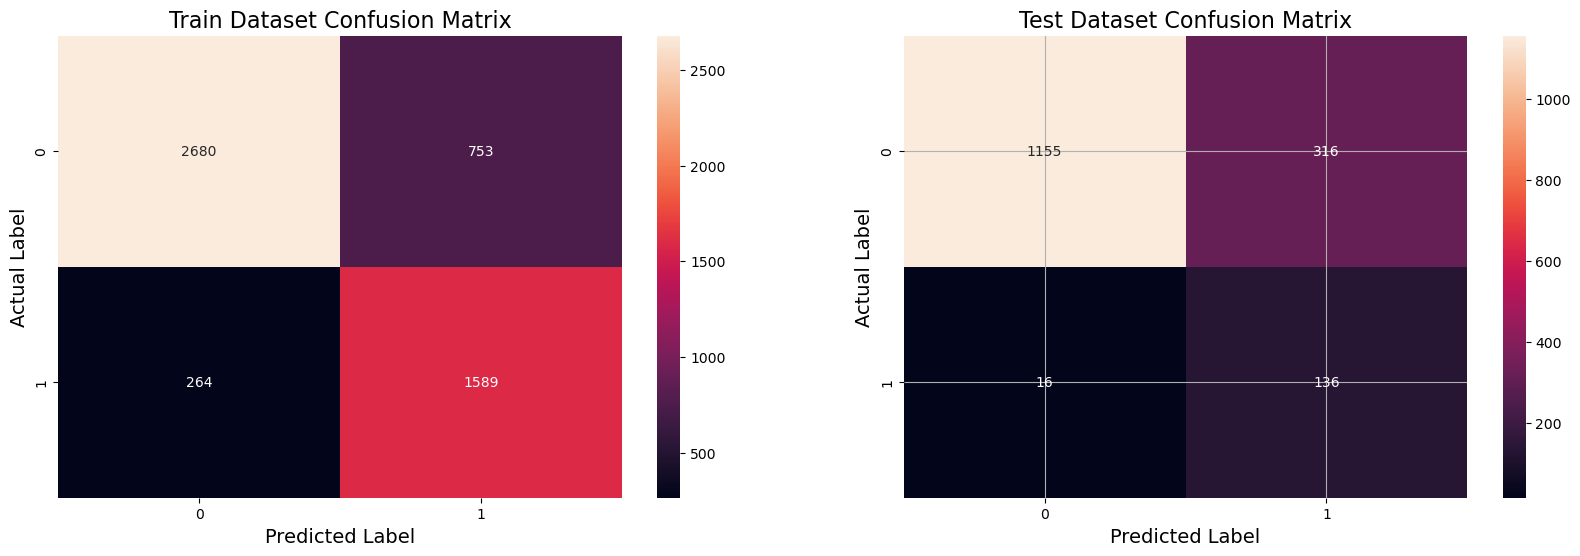

Best Threshold = 0.0000
Model AUC is : 0.8814
Model F1 Score is : 0.4503


In [ ]:
# Validate NB model
test_auc, test_f1_score, best_t = validate_model(gaussian_nb, x_tr_os, x_val, y_tr_os, y_val)

print("Best Threshold = {:.4f}".format(best_t))
print("Model AUC is : {:.4f}".format(test_auc))
print("Model F1 Score is : {:.4f}".format(test_f1_score))

In [ ]:
table = BeautifulTable()
table.column_headers= ["Model Name", "AUC", "F1 Score"]
table.append_row(["Logistic Regression", "0.95", "0.55"])
table.append_row(["Decision Tree", "0.88", "0.49"])
table.append_row(["Support Vector Classifier", "0.93", "0.52"])
table.append_row(["Naive Bayes", "0.88", "0.45"])
print(table)

+---------------------------+------+----------+
|        Model Name         | AUC  | F1 Score |
+---------------------------+------+----------+
|    Logistic Regression    | 0.95 |   0.55   |
+---------------------------+------+----------+
|       Decision Tree       | 0.88 |   0.49   |
+---------------------------+------+----------+
| Support Vector Classifier | 0.93 |   0.52   |
+---------------------------+------+----------+
|        Naive Bayes        | 0.88 |   0.45   |
+---------------------------+------+----------+


### Conclusion:
After comparing AUC and F1 scores accross all the models, I can observe that LogisticRegression performs the best. For SVC and Decision tree F! score is higher than LR. Still I will consider LR as the best model because AUC is high for LR.

### Oversample the data using SMOTE to make it 50:50 ratio

In [ ]:
oversample = SMOTE(sampling_strategy=1)
x_tr_os, y_tr_os = oversample.fit_resample(x_tr, y_tr)
counter = Counter(y_tr_os)
fraud_percentage = (counter[1]*100/(counter[0]+counter[1]))
non_fraud_percentage = (counter[0]*100/(counter[0]+counter[1]))
print("Fraud Percentage = {:.2f}% and Non-Fraud Percentage = {:.2f}%".format(fraud_percentage, non_fraud_percentage))

Fraud Percentage = 50.00% and Non-Fraud Percentage = 50.00%


### Train with LogisticRegression model

In [ ]:
log_reg = LogisticRegression(C=0.1, penalty='l2')
log_reg.fit(x_tr_os, y_tr_os)

C:\Users\Gurram koushik reddy\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(C=0.1)

Train AUC =  0.9506874088975009
Test AUC =  0.9426365880711296


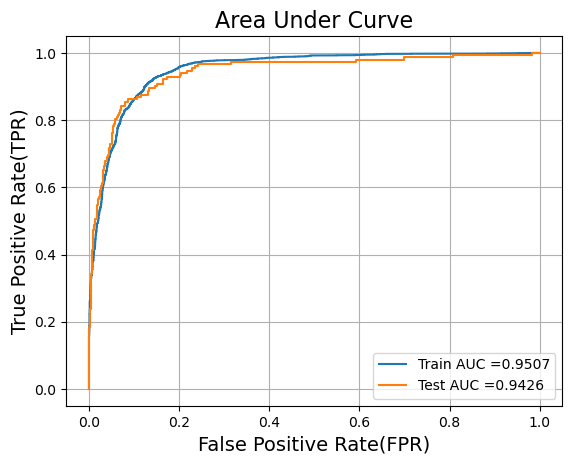

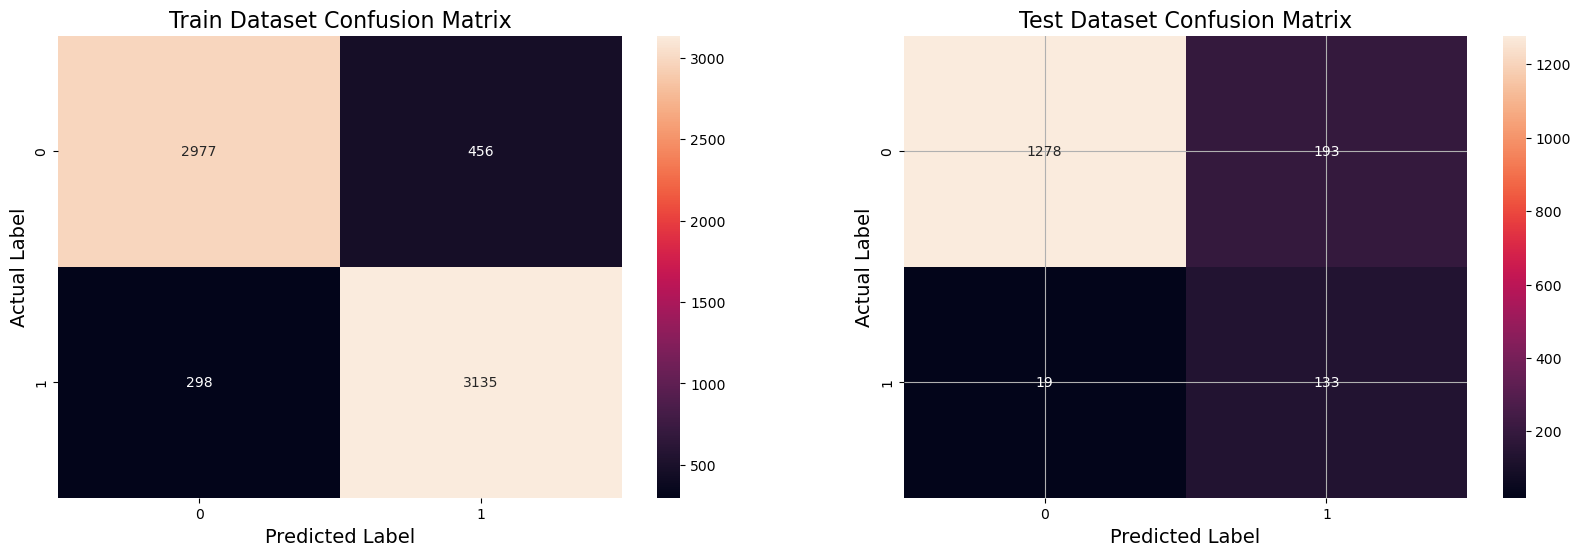

Best Threshold = 0.3363
Model AUC is : 0.9426
Model F1 Score is : 0.5565


In [ ]:
# Validate LogisticRegression model
test_auc, test_f1_score, best_t = validate_model(log_reg, x_tr_os, x_val, y_tr_os, y_val)

print("Best Threshold = {:.4f}".format(best_t))
print("Model AUC is : {:.4f}".format(test_auc))
print("Model F1 Score is : {:.4f}".format(test_f1_score))

### Train with DecisionTreeClassifier

In [ ]:
decision_tree = DecisionTreeClassifier(max_depth = 10, min_samples_split = 250)
decision_tree.fit(x_tr_os, y_tr_os)

DecisionTreeClassifier(max_depth=10, min_samples_split=250)

Train AUC =  0.9656802954887997
Test AUC =  0.9093661669469391


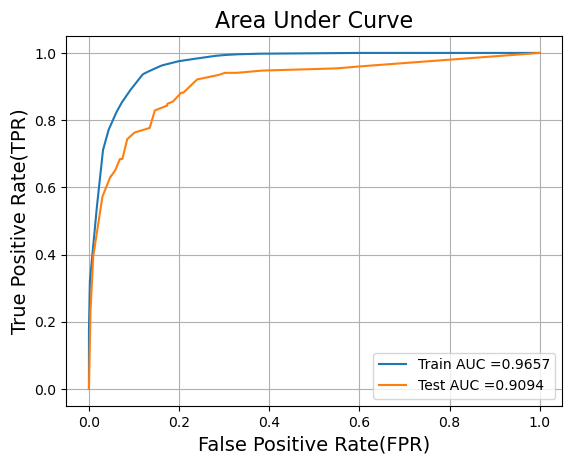

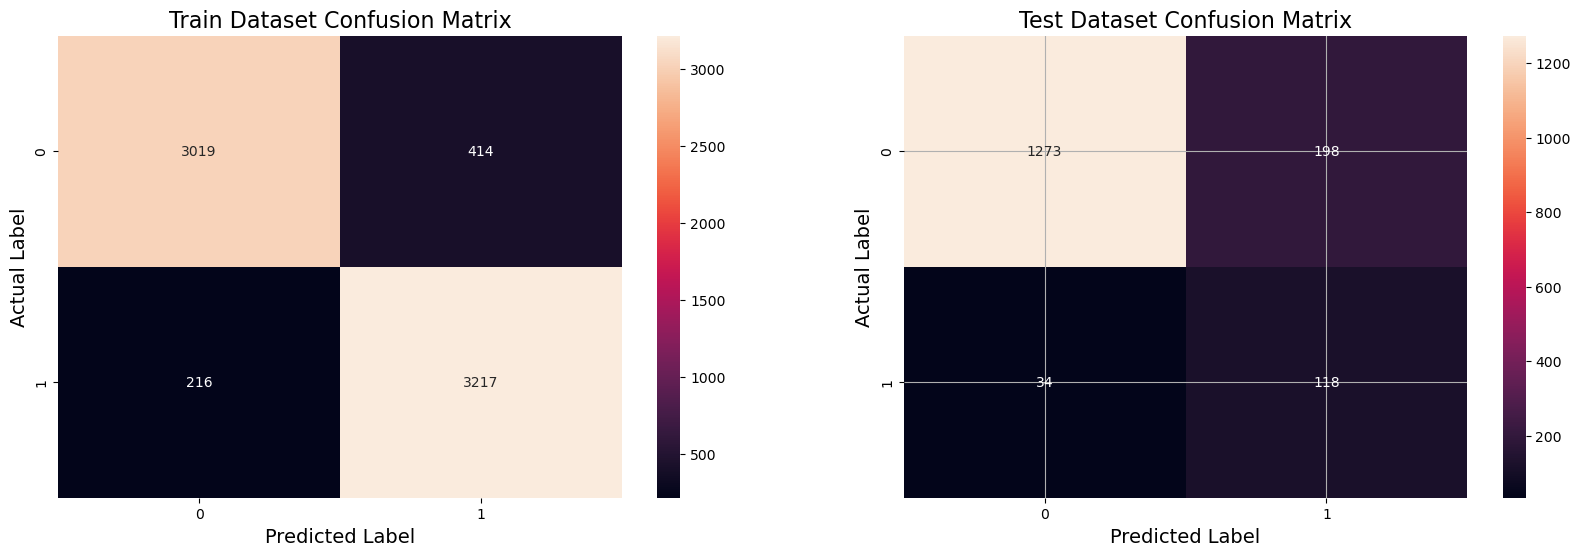

Best Threshold = 0.5294
Model AUC is : 0.9094
Model F1 Score is : 0.5043


In [ ]:
# Validate Decision Tree model
test_auc, test_f1_score, best_t = validate_model(decision_tree, x_tr_os, x_val, y_tr_os, y_val)

print("Best Threshold = {:.4f}".format(best_t))
print("Model AUC is : {:.4f}".format(test_auc))
print("Model F1 Score is : {:.4f}".format(test_f1_score))

### Train with Support Vector Classifier

In [ ]:
linear_svc = LinearSVC(C=1.0, penalty='l2')
clb_clf_svc = CalibratedClassifierCV(linear_svc)
clb_clf_svc.fit(x_tr_os, y_tr_os)

C:\Users\Gurram koushik reddy\anaconda3\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
C:\Users\Gurram koushik reddy\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Gurram koushik reddy\anaconda3\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
C:\Users\Gurram koushik reddy\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Gurram koushik reddy\anaconda3\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dua

CalibratedClassifierCV(estimator=LinearSVC())

Train AUC =  0.9596286585987227
Test AUC =  0.9382580772120648


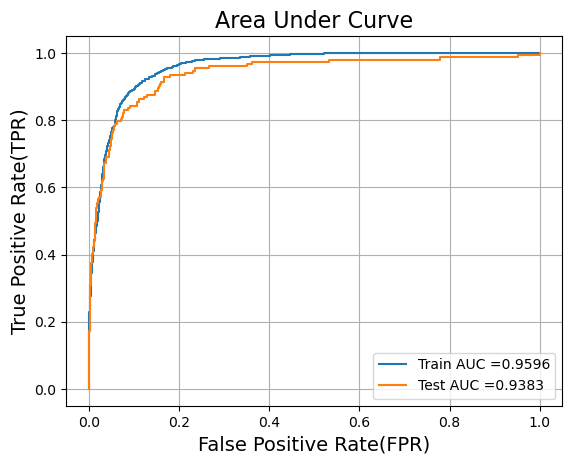

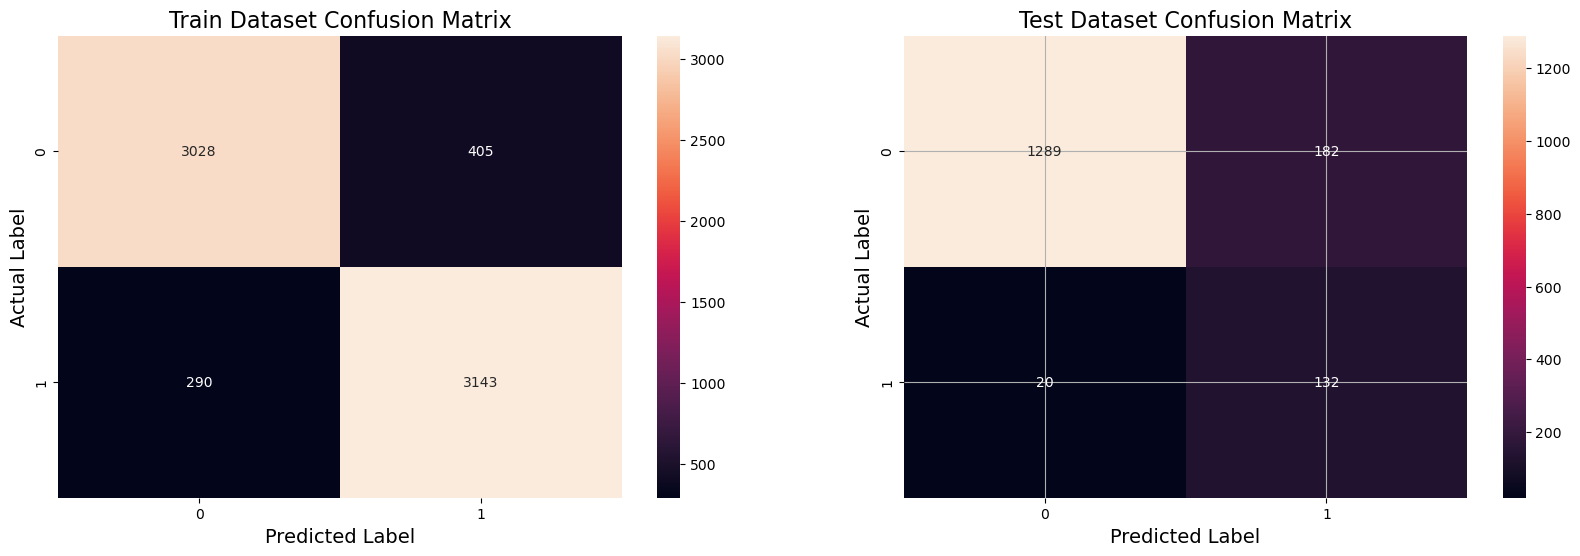

Best Threshold = 0.3629
Model AUC is : 0.9383
Model F1 Score is : 0.5665


In [ ]:
# Validate SVC model
test_auc, test_f1_score, best_t = validate_model(clb_clf_svc, x_tr_os, x_val, y_tr_os, y_val)

print("Best Threshold = {:.4f}".format(best_t))
print("Model AUC is : {:.4f}".format(test_auc))
print("Model F1 Score is : {:.4f}".format(test_f1_score))

### Train with NaiveBayes

In [ ]:
#Create a Gaussian Classifier
gaussian_nb = GaussianNB()
gaussian_nb.fit(x_tr_os, y_tr_os)


GaussianNB()

Train AUC =  0.8582007076668605
Test AUC =  0.8836586282156786


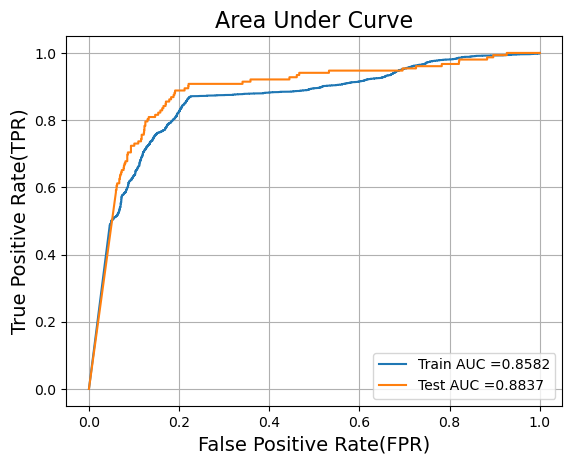

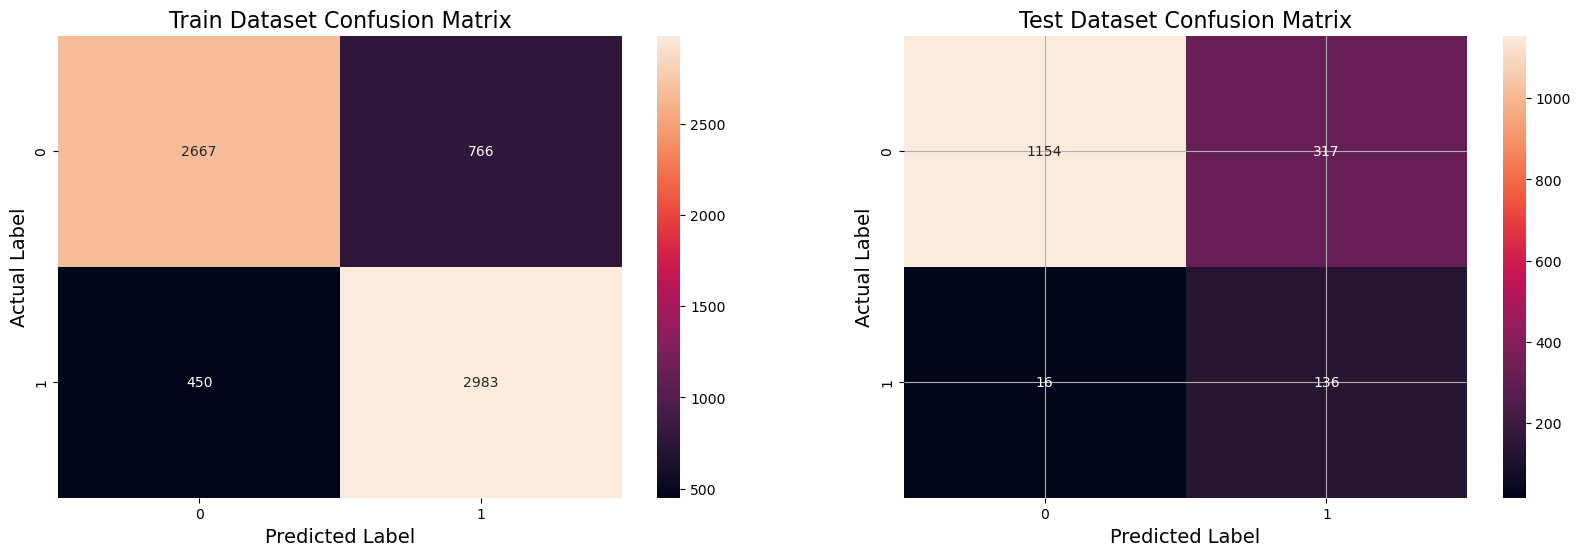

Best Threshold = 0.0000
Model AUC is : 0.8837
Model F1 Score is : 0.4496


In [ ]:
# Validate NB model
test_auc, test_f1_score, best_t = validate_model(gaussian_nb, x_tr_os, x_val, y_tr_os, y_val)

print("Best Threshold = {:.4f}".format(best_t))
print("Model AUC is : {:.4f}".format(test_auc))
print("Model F1 Score is : {:.4f}".format(test_f1_score))

In [ ]:
table = BeautifulTable()
table.column_headers= ["Model Name", "AUC", "F1 Score"]
table.append_row(["Logistic Regression", "0.94", "0.56"])
table.append_row(["Decision Tree", "0.91", "0.50"])
table.append_row(["Support Vector Classifier", "0.93", "0.56"])
table.append_row(["Naive Bayes", "0.88", "0.45"])
print(table)

+---------------------------+------+----------+
|        Model Name         | AUC  | F1 Score |
+---------------------------+------+----------+
|    Logistic Regression    | 0.94 |   0.56   |
+---------------------------+------+----------+
|       Decision Tree       | 0.91 |   0.5    |
+---------------------------+------+----------+
| Support Vector Classifier | 0.93 |   0.56   |
+---------------------------+------+----------+
|        Naive Bayes        | 0.88 |   0.45   |
+---------------------------+------+----------+


### Conclusion:
This time also after comparing AUC and F1 scores accross all the models, I can observe that LogisticRegression performs the best and SVC is the 2nd best.

### Overall observation accross all the sampling ratio.

In [ ]:
table = BeautifulTable()
table.column_headers= ["Sampling Ratio", "Best Model", "  AUC   ", "F1 Score"]
table.append_row(["80:20", "Logistic Regression", "0.95", "0.52"])
table.append_row(["75:25", "Logistic Regression", "0.95", "0.53"])
table.append_row(["65:35", "Logistic Regression", "0.95", "0.55"])
table.append_row(["50:50", "Logistic Regression", "0.94", "0.56"])
print(table)

+----------------+---------------------+----------+----------+
| Sampling Ratio |     Best Model      |   AUC    | F1 Score |
+----------------+---------------------+----------+----------+
|     80:20      | Logistic Regression |   0.95   |   0.52   |
+----------------+---------------------+----------+----------+
|     75:25      | Logistic Regression |   0.95   |   0.53   |
+----------------+---------------------+----------+----------+
|     65:35      | Logistic Regression |   0.95   |   0.55   |
+----------------+---------------------+----------+----------+
|     50:50      | Logistic Regression |   0.94   |   0.56   |
+----------------+---------------------+----------+----------+


### Conclusion:
Logistic Regression is performing good accross all the sampling ratio. But if we look at both AUC and F1 score, the model with Sampling Ratio 65:35 is the best model for this problem.